# Support Vector Machines

We use soft margin SVM as one of the other methods. We would like to optimise the parameters of SVM. We choose the kernel RBF, and thus have to consider two parameters $C$ and $\gamma$. 

In the sklearn implementation of SVM, a high value of $C$, means the classifier tries to classify all training examples correctly. This would cause overfitting. A low value would cause underfitting. Thus the perfect value is inbetween. 

$\gamma$ defines how local the model fits. A high $\gamma$ puts more emphasis on local training samples, thus leading to a more squiggly fit, which could cause overfitting. A low $\gamma$ puts less emphasis on local training examples leading to a smoother line. This could cause underfitting. Thus the optimal is in the middle. 

To choose the optimal hyperparameter values, we use GridSearchCV, followed by plotting the decision regions of each svm classifier


In [1]:
# Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sns
from mlxtend.plotting import plot_decision_regions

from sklearn.svm import SVC
from sklearn.metrics import *
from sklearn.model_selection import GridSearchCV

from LinearDiscriminantAnalysis import LDA_implemented
from NaiveBayes import NB_clf

from tqdm import tqdm

### Load data

In [2]:
train_data = np.load("data/fashion_train.npy")
X_train, y_train = train_data[:,:784], train_data[:,-1]

test_data = np.load("data/fashion_test.npy")
X_test, y_test = test_data[:,:784], test_data[:,-1]

N_CLASSES = len(np.unique(y_train))
CLOTHING_TYPES = {0: "T-shirt/top", 
                  1: "Trouser",
                  2: "Pullover",
                  3: "Dress",
                  4: "Shirt"}

CLOTHING_COLORS = {0: "darkorange", 
                   1: "lightseagreen",
                   2: "orangered",
                   3: "cornflowerblue",
                   4: "orchid"}

lda = LDA_implemented(4)
LDA_X_train = lda.fit_transform(X=X_train, y=y_train)
LDA_X_test = lda.transform(X_test)



LDA succesfully fitted and tranformed


### Gridsearch

In [4]:
gammas = [0.01,0.1,1,10]
Cs = [0.01,0.1,1,10]

param_grid = {
    'linear': {'C': Cs},  
    'poly': {'C': Cs, 'degree': [2, 3, 4]},  
    'rbf': {'C': Cs, 'gamma': gammas}  
}

best_params_kernel = {}

for kernel, param_grid_kernel in param_grid.items():
    svm = SVC(kernel=kernel)
    grid = GridSearchCV(estimator= svm, param_grid=param_grid_kernel, scoring='f1_macro', cv=3, verbose=1)
    grid.fit(LDA_X_train[:,:2],y_train)
    best_params_kernel[kernel] = grid.best_params_

for kernel, params in best_params_kernel.items():
    print(f'The optimal parameter(s) for the {kernel} kernel is/are {params}')

Fitting 3 folds for each of 4 candidates, totalling 12 fits
Fitting 3 folds for each of 12 candidates, totalling 36 fits
Fitting 3 folds for each of 16 candidates, totalling 48 fits
The optimal parameter(s) for the linear kernel is/are {'C': 1}
The optimal parameter(s) for the poly kernel is/are {'C': 10, 'degree': 3}
The optimal parameter(s) for the rbf kernel is/are {'C': 1, 'gamma': 0.01}


In [6]:
svm_LDA = SVC(kernel="linear", C=1)
svm_LDA.fit(LDA_X_train[:,:2], y_train)
LDA_y_pred = svm_LDA.predict(LDA_X_test[:,:2])
print("The linear kernel has a F1-score of", round(f1_score(y_test, LDA_y_pred, average="macro"), 3))

svm_LDA = SVC(kernel="poly", C=10, degree=3)
svm_LDA.fit(LDA_X_train[:,:2], y_train)
LDA_y_pred = svm_LDA.predict(LDA_X_test[:,:2])
print("The polynomial kernel has a F1-score of", round(f1_score(y_test, LDA_y_pred, average="macro"), 3))

svm_LDA = SVC(kernel="rbf", C=0.1, gamma=0.1)
svm_LDA.fit(LDA_X_train[:,:2], y_train)
LDA_y_pred = svm_LDA.predict(LDA_X_test[:,:2])
print("The RBF kernel has a F1-score of", round(f1_score(y_test, LDA_y_pred, average="macro"), 3))

The linear kernel has a F1-score of 0.728
The polynomial kernel has a F1-score of 0.707
The RBF kernel has a F1-score of 0.725


From the above GridSearchCV, we would probably choose a SVM classifier with a linear kernel. Not just because it performs the best in terms of macro F1-score, but also because it is the simplest kernel compared to the other kernels.  

The SVM classifier with a linear kernel and hyperparameter $C=1$ will be implemented below.

### Plotting decision boundaries

In [3]:
# Fit models
Cs = [0.01,0.1,1,100]
svms = []

for j in tqdm(range(len(Cs))):
    clf = SVC(kernel='linear', C=Cs[j])
    clf.fit(LDA_X_train[:,:2],y_train)
    svms.append(clf)

100%|██████████| 4/4 [00:38<00:00,  9.71s/it]


100%|██████████| 4/4 [00:22<00:00,  5.56s/it]


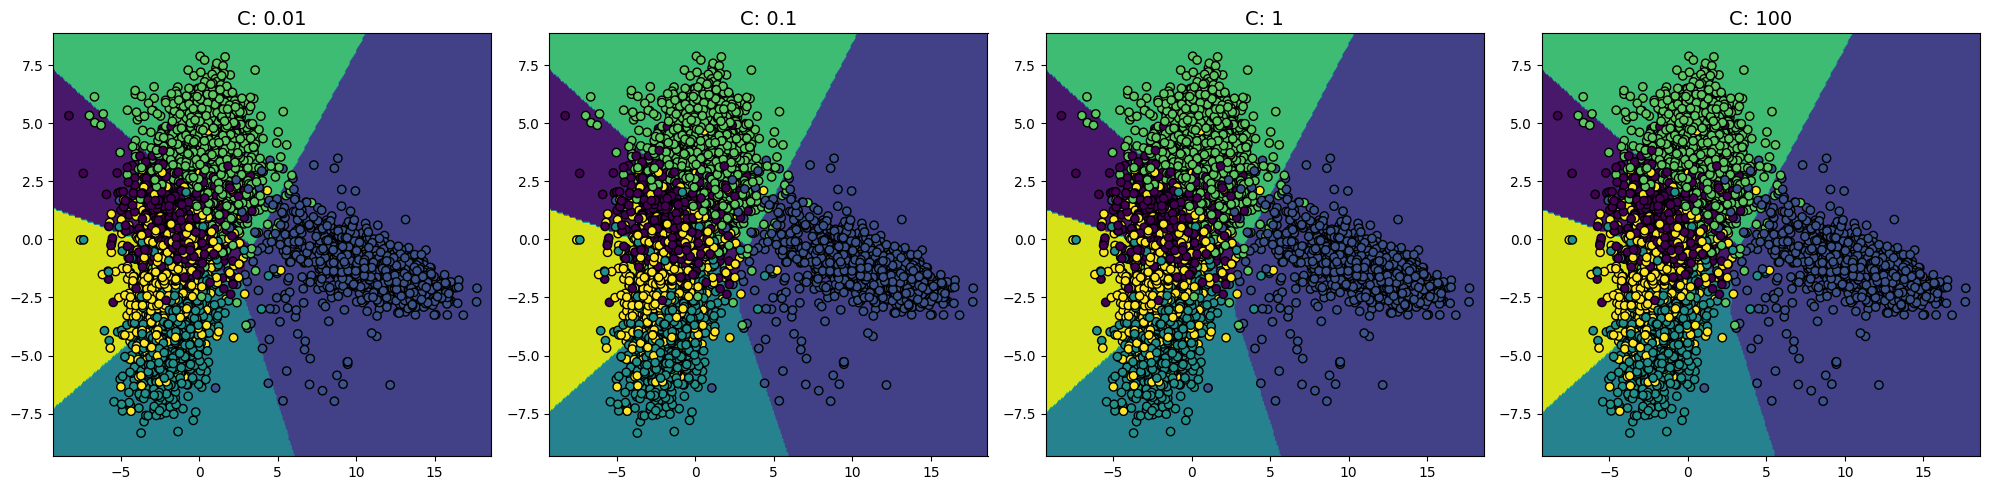

In [4]:
fig,ax = plt.subplots(nrows=1, ncols=4, figsize=(20,5))

h = 0.1

x_min, x_max = np.min(LDA_X_train[:,0])-1, np.max(LDA_X_train[:,0]) + 1
y_min, y_max = np.min(LDA_X_train[:,1])-1, np.max(LDA_X_train[:,1]) + 1

xx,yy = np.meshgrid(np.arange(x_min, x_max, h),
                    np.arange(y_min, y_max, h))

for j in tqdm(range(4)):
    Z = svms[j].predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    ax[j].contourf(xx,yy, Z)
    ax[j].scatter(LDA_X_train[:,0],LDA_X_train[:,1], c=y_train, marker='o', edgecolor='black')
    ax[j].set_xlim(xx.min(), xx.max());
    ax[j].set_ylim(yy.min(), yy.max());
    ax[j].set_title(f"C: {Cs[j]}", fontsize='14')

fig.tight_layout()

Most of the SVMs above have some overfitting. We don't see a lot of underfitting. From the above, we would probably choose the SVM with $C=1$ and $\gamma = 0.1$ or even $C=1$ and $\gamma = 0.01$

              precision    recall  f1-score   support

 T-shirt/top       0.59      0.74      0.66      1000
     Trouser       0.98      0.95      0.96      1000
    Pullover       0.72      0.78      0.75      1000
       Dress       0.81      0.80      0.80      1000
       Shirt       0.56      0.40      0.47      1000

    accuracy                           0.73      5000
   macro avg       0.73      0.73      0.73      5000
weighted avg       0.73      0.73      0.73      5000



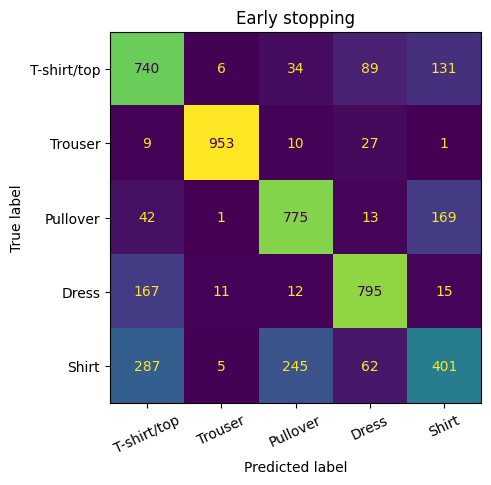

In [6]:
# computing and printing the performance metrics of the SVM classifier with linear kernel and C=1
svm_chosen = svms[2]
svm_pred = svm_chosen.predict(LDA_X_test[:,:2])
print(classification_report(y_true=y_test, y_pred=svm_pred, target_names=CLOTHING_TYPES.values()))

# plotting the confusion matrix
fig,ax = plt.subplots(ncols=1, figsize=(5,5))
ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_true=y_test, y_pred=svm_pred), 
                       display_labels=CLOTHING_TYPES.values()).plot(ax=ax, xticks_rotation=25, colorbar=False)
ax.grid(False)
ax.set_title("Early stopping")
fig.tight_layout()